# Spectral Extraction using `stark`

We have reduced calibrated data from `uncal` data using the jwst pipeline in another notebook. In the present notebook, we will extract timeseries of stellar spectra from those calibrated data. We will use `stark` package to do this.

The basic algorithm is similar to that from Horne's algorithm ([Horne 1986](https://iopscience.iop.org/article/10.1086/131801)) -- instead of using polynomials as a function of wavelength as in Horne (1986), `stark` fit splines to find a robust estimate of the stellar PSF. We derive one single PSF for _all_ frames (since pointing is stable and the background/sky is roughly the same, i.e., PSF doesn't change much with time) for a given wavelength (because PSF does change as a function of wavelength): to achieve this in practice we fit a 2D spline as a function of spatial coordinate (i.e., distance from the trace) and wavelength. Once we have estimate of PSF, we can use it to derive stellar spectra for each frame. This will give us transit lightcurves for each wavelengths. Averaging over wavelength would give us white-light lightcurve.

We will fit a transit lightcurve to the data once we have white-light lightcurve.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import utils
from stark import SingleOrderPSF, optimal_extract
from tqdm import tqdm
from pathlib import Path
from poetss import poetss
import pickle

In [2]:
visit = 'NRSPR'

# Input and Output paths
p1 = '/'.join(os.getcwd().split('/')[:-1])
pin = p1 + '/RateInts/Corr_' + visit
pout = p1 + '/NRSPR/Outputs/'
if not Path(pout + '/Figures').exists():
    os.mkdir(pout + '/Figures')

## Segment!!!
segs = []
for i in range(4):
    if i < 9:
        segs.append('00' + str(i+1))
    else:
        segs.append('0' + str(i+1))
segs = ['004']
xstart, xend = 15, 480
aprad = 7.

corrected_data = np.load(pin + '/Corrected_data_seg' + segs[0] + '.npy')
corrected_errs = np.load(pin + '/Corrected_errors_seg' + segs[0] + '.npy')
mask_bcr = np.load(pin + '/Mask_bcr_seg' + segs[0] + '.npy')
time_bjd = np.load(pin + '/Times_bjd_seg' + segs[0] + '.npy')
for i in range(len(segs)-1):
    ## Data
    data1 = np.load(pin + '/Corrected_data_seg' + segs[i+1] + '.npy')
    corrected_data = np.vstack((corrected_data, data1))
    ## Errors
    errs1 = np.load(pin + '/Corrected_errors_seg' + segs[i+1] + '.npy')
    corrected_errs = np.vstack((corrected_errs, errs1))
    ## Masks
    msk1 = np.load(pin + '/Mask_bcr_seg' + segs[i+1] + '.npy')
    mask_bcr = np.vstack((mask_bcr, msk1))
    ## Times
    tim12 = np.load(pin + '/Times_bjd_seg' + segs[i+1] + '.npy')
    time_bjd = np.hstack((time_bjd, tim12))

time_bjd = time_bjd + 2400000.5
nint = np.random.randint(0, corrected_data.shape[0])

The first step of the procedure is to find the trace positions -- we will use center-of-flux method to find location of spectral trace at each wavelength column for every time integration. `poetss` has an in-built function for this.

In [3]:
def pipe_mad(data):
    return np.nanmedian(np.abs(np.diff(data, axis=0)), axis=0)

Text(0.5, 1.0, 'Example data with the location of spectral trace')

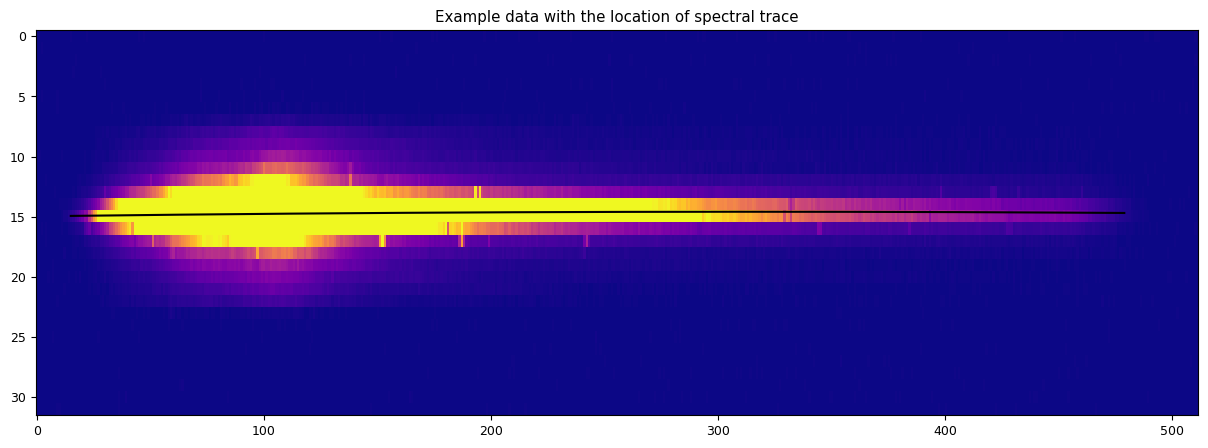

In [4]:
# Finding trace
cent_cub1 = poetss.find_trace_cof(clean_cube=corrected_data[:,:,xstart:xend], margin=5)
trace1, dx1 = poetss.fit_multi_trace(cent_mat=cent_cub1, deg=3, clip=3)
xpos = np.arange(xstart, xend, 1)
#mask_nan = np.copy(mask_bcr)
#mask_nan[mask_bcr == 0] = np.nan
#xpos, trace1, dx1 = trace_pos(data=corrected_data*mask_nan, xstart=15, xend=480, ystart=12, yend=18)

ypos2d = np.zeros((corrected_data.shape[0], len(xpos)))
for i in range(ypos2d.shape[0]):
    ypos2d[i,:] = trace1 + dx1[i]

plt.figure(figsize=(15,5))
im = plt.imshow(corrected_data[nint,:,:], interpolation='none', aspect='auto', cmap='plasma')
im.set_clim([0,5e3])
plt.plot(xpos, trace1, 'k-')
plt.title('Example data with the location of spectral trace')

What we plot above is the median trace location -- on the top of this there should be a jitter of trace as a function of time. Let's plot that jitter below:

3844.272885908495


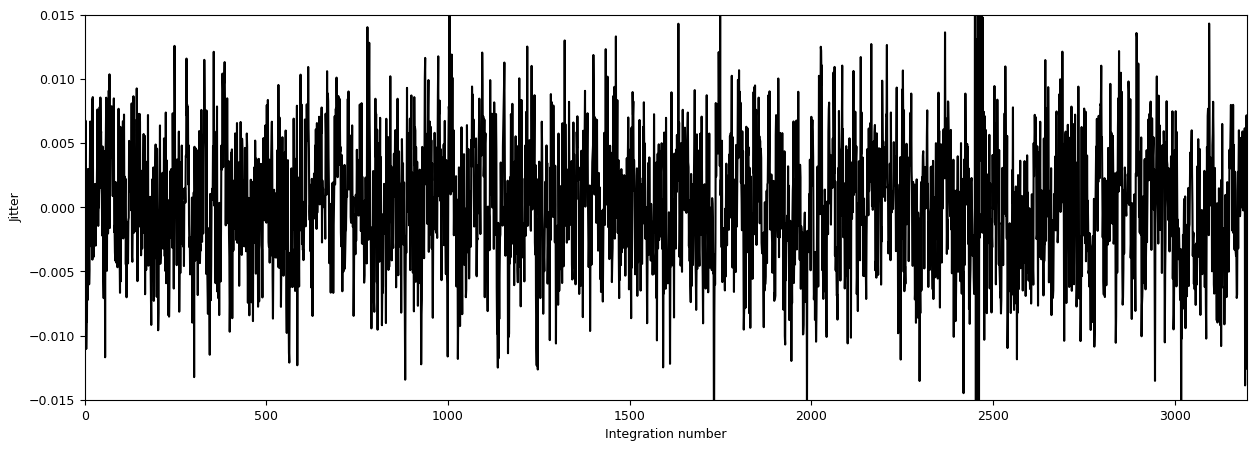

In [5]:
plt.figure(figsize=(15,5))
plt.plot(np.arange(len(dx1)), dx1, 'k-')
plt.ylim([-0.015, 0.015])
plt.xlim([0, corrected_data.shape[0]])
plt.xlabel('Integration number')
plt.ylabel('Jitter')

print(pipe_mad(dx1*1e6))

Jitter is very small at ~0.01 pix level -- that is very good! So, we will use these trace positions to identify the location of trace on data.

## Initial estimate of PSF

We mentioned above that while PSF would not change with time, it will change significantly with wavelength. So, we want to fit a 2D spline to get a robust estimate of PSF. However, before doing that, let's approximate that the PSF doesn't change with wavelength. This assumption can give us a first rough estimate of stellar spectra which we can use as normalisation constant in next step.

So, let's fit 1D spline to the data as a function of spatial coordinate, i.e., distance from trace. In `stark` we first create a `stark` data object using `SingleOrderPSF` class which will load data. This class will take the data, variance, masked pixels, aperture half-widths and trace locations as inputs. Note that the `SingleOrderPSF` takes 3D arrays as data, variance and masked pixels with dimensions of (nFrames, nRows, nCols) assuming the trace run along the row. Similarly trace locations are a 2D array giving trace positions for each integration (nFrames, TraceLocations).

Once we load the data, we can fit a 1D spline using `univariate_psf_frame` method, which will return PSF frame and best-fitted spline object.

Iter 1 / 3: 3.47030 per cent masked.
Iter 2 / 3: 3.47118 per cent masked.
Iter 3 / 3: 3.47124 per cent masked.


Text(0, 0.5, 'Normalised flux')

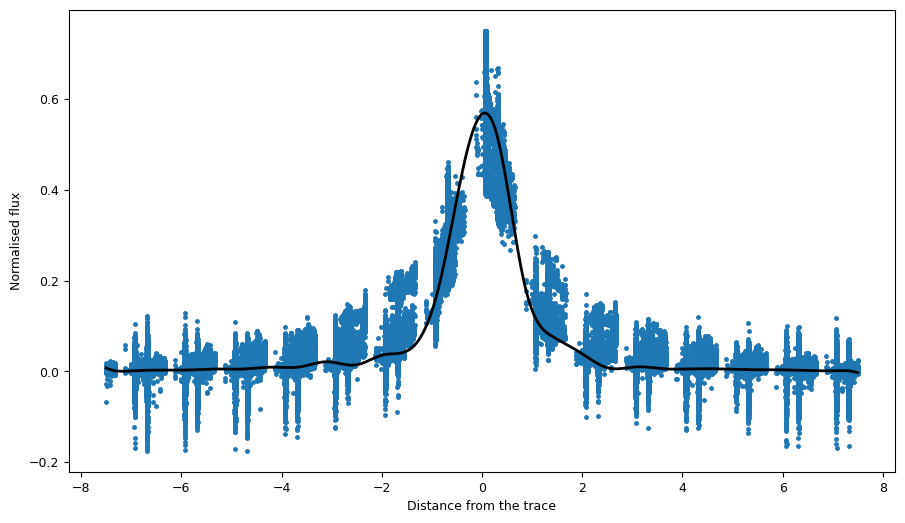

In [6]:
data1d = SingleOrderPSF(frame=corrected_data[:,:,xpos[0]:xpos[-1]+1],\
                        variance=corrected_errs[:,:,xpos[0]:xpos[-1]+1]**2,\
                        ord_pos=ypos2d, ap_rad=aprad, mask=mask_bcr[:,:,xpos[0]:xpos[-1]+1])
psf_frame1d, psf_spline1d, msk_updated_1d = data1d.univariate_psf_frame(niters=3, oversample=2, clip=10)

ts1 = np.linspace(np.min(data1d.norm_array[:,0]), np.max(data1d.norm_array[:,0]), 1000)
msk1 = np.asarray(data1d.norm_array[:,4], dtype=bool) * msk_updated_1d
plt.figure(figsize=(16/1.5, 9/1.5))
plt.errorbar(data1d.norm_array[msk1,0], data1d.norm_array[msk1,1], fmt='.')
plt.plot(ts1, psf_spline1d(ts1), c='k', lw=2., zorder=10)
plt.xlabel('Distance from the trace')
plt.ylabel('Normalised flux')

Nice! Above plot shows all data points (in blue) as a function of distance from trace and black line is the best-fitted PSF. As a first estimate this is looking very good. The PSF-fitting procedure from above also updated the bad-pixel map since we performed sigma clipping while fitting the PSF. So, let's first update the bad-pixel map.

Text(0.5, 1.0, 'Updated bad-pixel map')

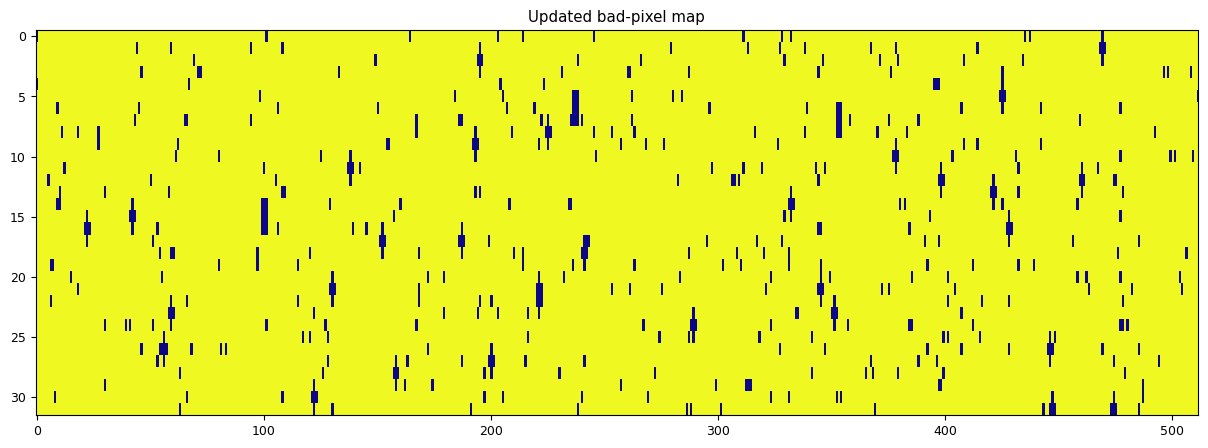

In [7]:
msk_2d = data1d.table2frame(msk_updated_1d)
mask_badpix_updated = np.copy(mask_bcr)
mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1] = mask_bcr[:,:,xpos[0]:xpos[-1]+1] * msk_2d

plt.figure(figsize=(15,5))
plt.imshow(mask_badpix_updated[0,:,:], interpolation='none', cmap='plasma', aspect='auto')
plt.title('Updated bad-pixel map')

Let's now use this PSF to find timeseries of stellar spectra using `optimal_extract` function.

In [8]:
spec1d, var1d = np.zeros((psf_frame1d.shape[0], psf_frame1d.shape[2])), np.zeros((psf_frame1d.shape[0], psf_frame1d.shape[2]))
syth1d = np.zeros(psf_frame1d.shape)
for inte in tqdm(range(spec1d.shape[0])):
    spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame1d[inte,:,:],\
                                                                      data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                      mask=mask_badpix_updated[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      ord_pos=ypos2d[inte,:], ap_rad=aprad)

100%|██████████| 3200/3200 [00:31<00:00, 103.21it/s]


We now have a first estimate of timeseries of stellar spectra. We can use this as a normalising contant in the next step.

## Robust estimate of PSF

As already mentioned, while PSF doesn't change much with time, it does change with wavelength. So, our above approximation of assuming a constant PSF with wavelength was not good. To take care of this, we will now assume that PSF changes with wavelength and we will fit a 2D spline to the data as a function of spatial direction and wavelength. To do so, we will first load the data as previously, but now we will provide initial estimate of spectra to use it as a normalising constant.

After loading the data we will use `bivariate_psf_frame` method to fit 2D spline to this data:

In [9]:
data2 = SingleOrderPSF(frame=corrected_data[:,:,xpos[0]:xpos[-1]+1],\
                       variance=corrected_errs[:,:,xpos[0]:xpos[-1]+1]**2,\
                       ord_pos=ypos2d, ap_rad=aprad, mask=mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1],\
                       spec=spec1d)
psf_frame2d, psf_spline2d, msk_after2d = data2.bivariate_psf_frame(niters=3, oversample=2, knot_col=10, clip=10)

Iter 1 / 3: 3.61330 per cent masked.
Iter 2 / 3: 3.69608 per cent masked.
Iter 3 / 3: 3.72667 per cent masked.


Before finding the time-series of spectra, let's see how we well we fit the splines. For this, we will visualise data and fitted splines for one given colum.

Text(0, 0.5, 'Normalised flux')

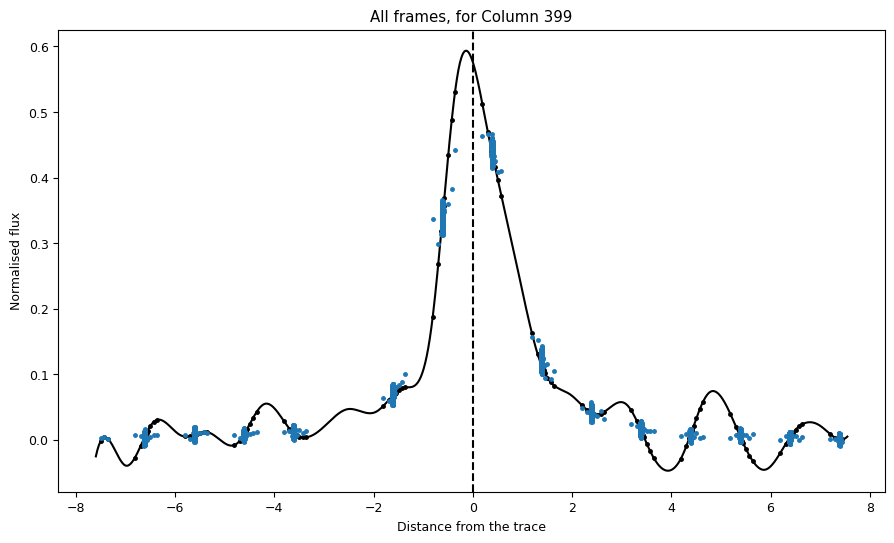

In [10]:
ncol = np.random.choice(xpos)
des_pts, cont_pts = utils.spln2d_func(ncol1=ncol-xpos[0], datacube=data2)
fits_2d = psf_spline2d(cont_pts[0], cont_pts[1], grid=False)

plt.figure(figsize=(16/1.5,9/1.5))
plt.errorbar(des_pts[0], des_pts[2], fmt='.')
plt.plot(cont_pts[0], fits_2d, 'k-')
plt.plot(des_pts[0], psf_spline2d(des_pts[0], des_pts[1], grid=False), 'k.')
plt.axvline(0., color='k', ls='--')
plt.title('All frames, for Column ' + str(ncol))
plt.xlabel('Distance from the trace')
plt.ylabel('Normalised flux')

The blue and black (barely visible) points are original data points and their estimated value based on the best fitted spline (black line). The fitted spline is slightly asymmetric but that is okay. Overall, we did a good job.

Now, we mentioned that the main reason to use 2D splines was that the PSF was not constant as a function of wavelength. So, let's now see how PSF (i.e., its amplitude and FWHM) changes with wavelength.

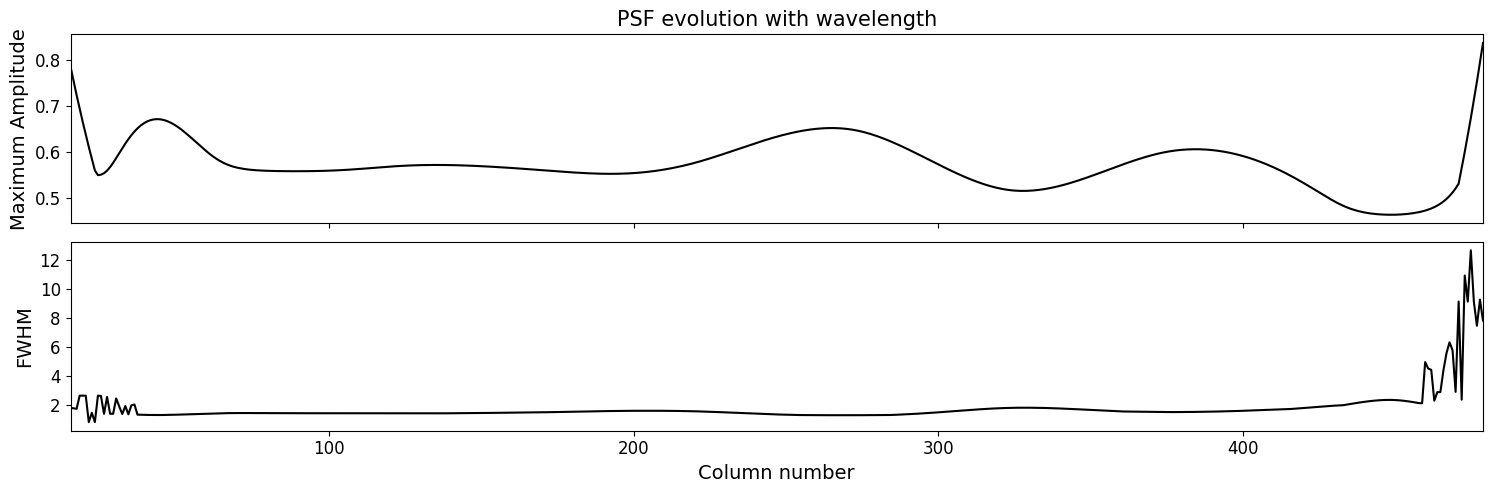

In [11]:
# Defining pixel coordinates
pix_cor_res = 50000
pix_corr = np.linspace(-7., 7., pix_cor_res)

cols = xpos - xpos[0]
max_amp = np.zeros(len(cols))
fwhm = np.zeros(len(cols))

for i in range(len(cols)):
    fit2 = psf_spline2d(x=pix_corr, y=np.ones(pix_cor_res)*cols[i], grid=False)
    # Maximum amplitude
    max_amp[i] = np.max(fit2)
    # Maximum amplitude location
    idx_max_amp = np.where(fit2 == np.max(fit2))[0][0]
    # fwhm
    hm = (np.max(fit2) + np.min(fit2))/2
    idx_hm = np.where(np.abs(fit2 - hm)<0.005)[0]
    idx_hm_up, idx_hm_lo = 0, 0
    diff_up1, diff_lo1 = 10., 10.
    for j in range(len(idx_hm)):
        if idx_hm[j] > idx_max_amp:
            diff_u1 = np.abs(fit2[idx_hm[j]] - hm)
            if diff_u1 < diff_up1:
                diff_up1 = diff_u1
                idx_hm_up = idx_hm[j]
        else:
            diff_l1 = np.abs(fit2[idx_hm[j]] - hm)
            if diff_l1 < diff_lo1:
                diff_lo1 = diff_l1
                idx_hm_lo = idx_hm[j]
    fwhm[i] = np.abs(pix_corr[idx_hm_up] - pix_corr[idx_hm_lo])

fig, axs = plt.subplots(2, 1, figsize=(15, 5), sharex=True, facecolor='white')

axs[0].plot(xpos, max_amp, 'k-')
axs[0].set_ylabel('Maximum Amplitude', fontsize=14)

axs[1].plot(xpos, fwhm, 'k-')
axs[1].set_ylabel('FWHM', fontsize=14)
axs[1].set_xlabel('Column number', fontsize=14)

axs[1].set_xlim([xpos[0], xpos[-1]])

axs[0].set_title('PSF evolution with wavelength', fontsize=15)

plt.setp(axs[0].get_yticklabels(), fontsize=12)
plt.setp(axs[1].get_xticklabels(), fontsize=12)
plt.setp(axs[1].get_yticklabels(), fontsize=12)

plt.tight_layout()

That's a bit odd -- in first few iterations, FWHM drops abruptly and then varies smoothly. This maybe because we used `oversample=2` while fitting the 2D spline. When we do this, we put 2 times more knots in the spatial direction, and this could make PSF more noisy (or, more wiggly). One can use `oversample=1` (the default option) which would put 1 knot per pixel -- while this could "stablise" the PSF, its fitting to the data will not be as good.

Again, we will update the mask since we performed a sigma-clipping when fitting a 2D spline.

Text(0.5, 1.0, 'Updated bad-pixel map')

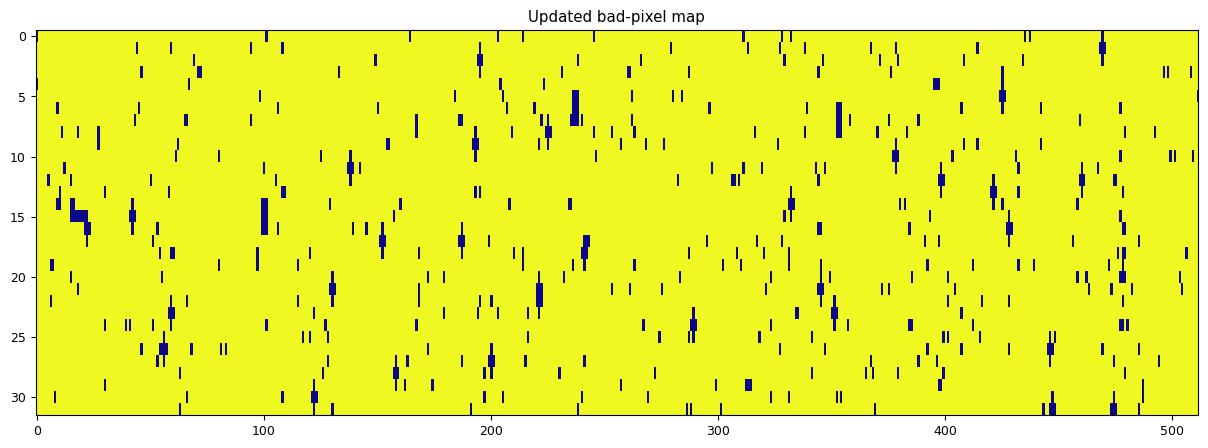

In [12]:
msk_2d2d = data2.table2frame(msk_after2d)
mask_badpix_updated2d = np.copy(mask_badpix_updated)
mask_badpix_updated2d[:,:,xpos[0]:xpos[-1]+1] = mask_badpix_updated[:,:,xpos[0]:xpos[-1]+1] * msk_2d2d

plt.figure(figsize=(15,5))
plt.imshow(mask_badpix_updated2d[0,:,:], interpolation='none', cmap='plasma', aspect='auto')
plt.title('Updated bad-pixel map')

### Aperture half-width selection

Now, we want to use this PSF to extract the stellar spectra. Until now, we were using aperture half-width of 9 pixels to fit the splines and to extract the spectra. And that is totally fine. However, it could be possible that by changing the aperture half-width one could get a lower scatter in the final white-light lightcurve. So, what we will do below is to extract spectra for a series of aperture half-widths from 2 to 9 pixels. After spectral extraction we will compute a white-light lightcurve by taking weighted average of all spectroscopic lightcurves (i.e., flux as a function of time for each wavelengths). Finally, we will compute the MAD of this lightcurve and compare it with MAD value of white-light lightcurves found with different apertures. We will select the aperture with minimum MAD on white-light lightcurve.

100%|██████████| 3200/3200 [00:31<00:00, 101.36it/s]


Text(0, 0.5, 'MAD of white-light lightcurve')

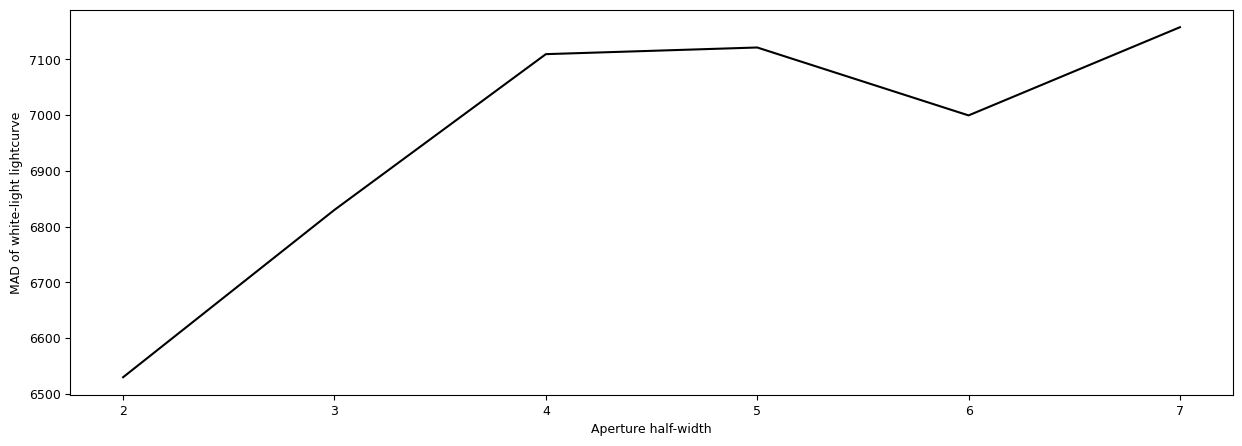

In [13]:
apertures = np.arange(2,aprad+1,1)
scatter = np.zeros(len(apertures))

for aps in range(len(apertures)):
    spec1d, var1d = np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2])), np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2]))
    syth1d = np.zeros(psf_frame2d.shape)
    for inte in tqdm(range(spec1d.shape[0])):
        spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame2d[inte,:,:],\
                                                                          data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                          variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                          mask=mask_badpix_updated2d[inte,:,xpos[0]:xpos[-1]+1],\
                                                                          ord_pos=ypos2d[inte,:], ap_rad=apertures[aps])
    # Computing white-light lightcurve
    wht_lc, wht_err = poetss.white_light(spec1d, np.sqrt(var1d))
    # And its scatter
    scatter[aps] = pipe_mad(wht_lc/np.nanmedian(wht_lc)) * 1e6

plt.figure(figsize=(15,5))
plt.plot(apertures, scatter, 'k-')
plt.xlabel('Aperture half-width')
plt.ylabel('MAD of white-light lightcurve')

Perfect! We now have an optimal aperture size. We will use this aperture size to extract spectra again:

In [14]:
min_scat_ap = apertures[np.argmin(scatter)]

spec1d, var1d = np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2])), np.zeros((psf_frame2d.shape[0], psf_frame2d.shape[2]))
syth1d = np.zeros(psf_frame2d.shape)
for inte in tqdm(range(spec1d.shape[0])):
    spec1d[inte,:], var1d[inte,:], syth1d[inte,:,:] = optimal_extract(psf_frame=psf_frame2d[inte,:,:],\
                                                                      data=corrected_data[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      variance=corrected_errs[inte,:,xpos[0]:xpos[-1]+1]**2,\
                                                                      mask=mask_badpix_updated2d[inte,:,xpos[0]:xpos[-1]+1],\
                                                                      ord_pos=ypos2d[inte,:], ap_rad=min_scat_ap)

100%|██████████| 3200/3200 [00:30<00:00, 106.32it/s]


Let's plot all spectra (extracted at different times) on the top of each other:

Text(0.5, 1.0, 'Timeseries of spectra')

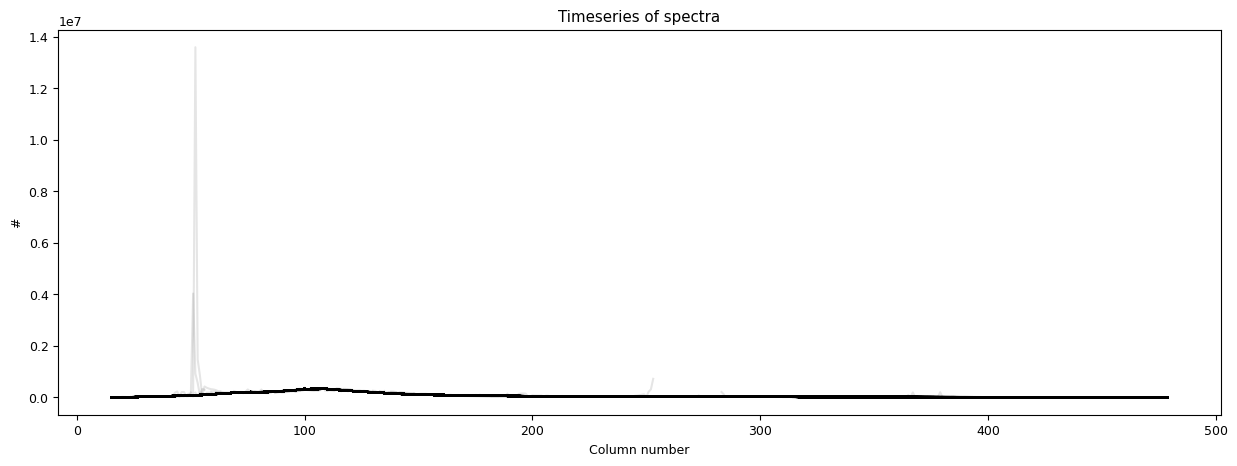

In [15]:
plt.figure(figsize=(15,5))
for i in range(spec1d.shape[0]):
    plt.plot(xpos, spec1d[i,:], 'k', alpha=0.1)
plt.xlabel('Column number')
plt.ylabel('#')
plt.title('Timeseries of spectra')

Good! The scatter (or the width) that we see above is because the level of flux changes during the transit event.

### Residual frame

When we fit 2D spline to the data, we are basically modelling the trace. So, in principle, we do spectral extraction, we should have a synthetic model of the data. Indeed, we were saving this model for each time when we performed spectral extraction using `optimal_extract` function. We can subtract this sythetic model from our dataset to find what is called residual frame. Ideally, this frame should look like a white-noise. If not there is some left-over noise in the data or spline fitting was not perfect. 

In any case the median residual frame should show us the static leftover noise that was not fitted. If one find any such noise one can subtract this median residual frame from our original data and repeat the whole procedure of spline fitting until there remains only white noise in the median residual frame.

So, now, let's see how the median residual frame looks like:

Text(0.5, 1.0, 'Median residual frame')

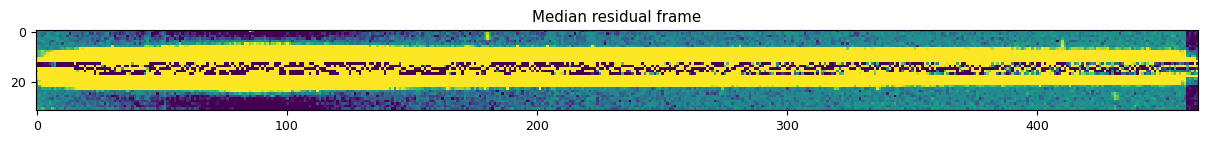

In [16]:
resid1 = np.zeros(syth1d.shape)
for j in range(resid1.shape[0]):
    resid1[j,:,:] = corrected_data[j,:,xpos[0]:xpos[-1]+1] - syth1d[j,:,:]

med_resid = np.nanmedian(resid1, axis=0)

plt.figure(figsize=(15,5))
im = plt.imshow(med_resid, interpolation='none')#, aspect='auto')
im.set_clim([-5,5])
#plt.xlim([0,315])
#plt.ylim([20,40])
plt.title('Median residual frame')

Ahh good! Maybe there is some structure in these image -- but for the purpose of this analysis, we can safely assume that this is just some white-noise. Interested reader can subtract this median residual image from each dataframe and repeat the whole procedure of spline fitting again. That would definately remove any leftover static noise.

### Lightcurves

Now, we will compute white-light lightcurve by taking a weighted average of spectroscopic lightcurves (i.e., timeseries of flux at each wavelength). `poetss` has an inbuilt function for this which we will use below.

(0.97, 1.03)

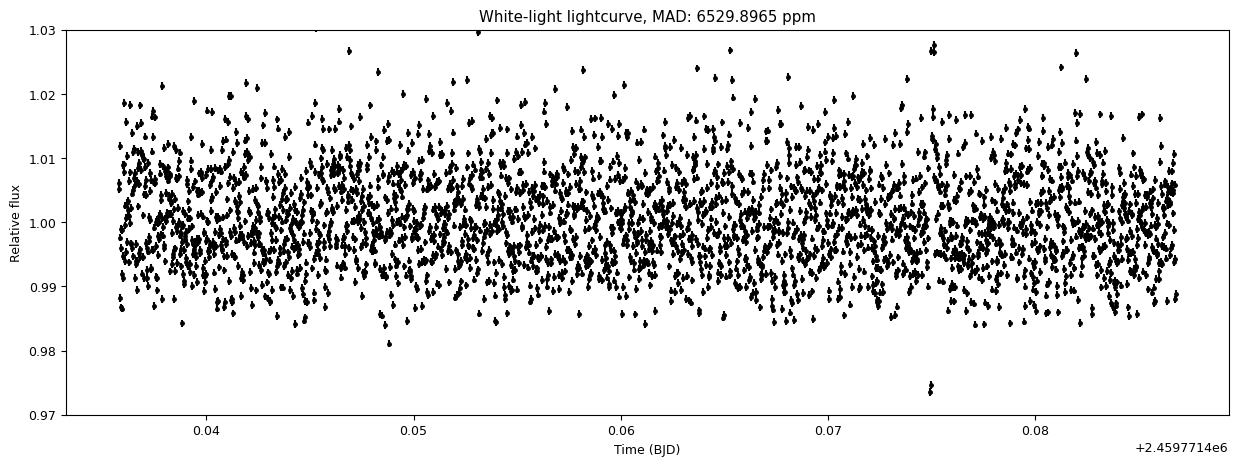

In [19]:
wht_light_lc, wht_light_err = poetss.white_light(spec1d, np.sqrt(var1d))

plt.figure(figsize=(15,5))
plt.errorbar(time_bjd, wht_light_lc/np.nanmedian(wht_light_lc), \
             yerr=wht_light_err/np.nanmedian(wht_light_lc), fmt='.', c='k')
plt.title('White-light lightcurve, MAD: {:.4f} ppm'.format(pipe_mad(wht_light_lc/np.nanmedian(wht_light_lc)) * 1e6))
plt.xlabel('Time (BJD)')
plt.ylabel('Relative flux')
plt.ylim([0.97,1.03])

Let's just save our results:

In [ ]:
# Dictionary for saving the final results
dataset = {}
dataset['spectra'] = spec1d
dataset['variance'] = var1d
dataset['resid'] = resid1
dataset['times'] = time_bjd
pickle.dump(dataset, open(pout + '/Spectrum_cube_' + visit + '.pkl','wb'))

psf_res = {}
psf_res['psf'] = psf_frame2d
psf_res['spline'] = psf_spline2d
pickle.dump(psf_res, open(pout + '/PSF_data_' + visit + '.pkl','wb'))

pickle.dump(data2, open(pout + '/Dataset2_' + visit + '.stk','wb'))